In [59]:
import pandas as pd
import pickle as pkl
import seaborn as sns
from numpy import mean
from matplotlib import pyplot as plt
import lightgbm as lgbm

In [60]:
%cd /Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital/

/Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital


### Load model

In [61]:
with open(r"experiments/optimized_gdbt_model.pkl", "rb") as input_file:
    lgbm_model = pkl.load(input_file)

### Load data

In [62]:
import os
import pandas as pd
from matplotlib import pyplot as plt   
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from thesis_lib.utils import * 
from thesis_lib.modelling.data import *
from thesis_lib.modelling.model import *
data = Data().load('data/hospital_dataset')
data.get_stats()

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet
Loading dataset:  hospital_test_data.parquet


dataset_type,train,val,test
n_observations,319150,33482,33309
relative_size,0.82694,0.0867542,0.0863059
n_cols,71,71,71
positives,42697,4555,4507
negatives,276453,28927,28802
positive_prop,0.133783,0.136043,0.135309
negative_prop,0.866217,0.863957,0.864691
min_date,2017-01-01,2018-11-11,2018-11-11
max_date,2018-11-10,2019-11-11,2019-11-11


### Generate probabilities

In [63]:
lgbm_model.transform(data, transform_test=True)

Fitting pipeline...
Transforming data...


In [64]:
predicted_prob_test = lgbm_model.predict(lgbm_model.X_test)
#y_test_pred = pd.DataFrame({'predicted_prob':predicted_prob_test})

In [65]:
from sklearn.metrics import roc_curve,auc

In [66]:
fpr, tpr, _ = roc_curve(data.test.y,predicted_prob_test)

In [67]:
roc_auc = auc(fpr,tpr)

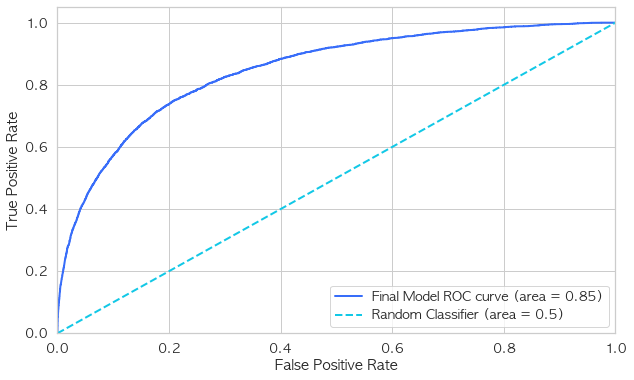

In [68]:
sns.set(style="whitegrid",font_scale=1.2,font='AppleGothic', palette="rainbow")
plt.figure(figsize=(10,6))
lw = 2
plt.plot(fpr, tpr,
         lw=lw, label='Final Model ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--', label = 'Random Classifier (area = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [69]:
data.test.X.reset_index(inplace=True)

X_test= data.test.X.join(y_test_pred)
y_test = data.test.y.reset_index()
X_test = X_test.join(y_test['discharge'])
#pd.set_option('display.max_columns', None)
df = X_test[['date','predicted_prob','discharge']]

NameError: name 'y_test_pred' is not defined

In [8]:
df.to_parquet('test_data_w_predictions.parquet')

In [70]:
df = pd.read_parquet('test_data_w_predictions.parquet')

### Simulate forecast

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [72]:
from tqdm import tqdm

results = {'threshold': [],
           'date':[],
           'actual_discharges': [],
           'predicted_discharges': [],
           'patients': [],
           'accuracy': [],
           'precision': [],
           'recall': []}

unique_dates = list(df.date.unique())

for i in tqdm(range(0,100,1)):
    threshold = i/100
    df['predicted_discharges'] = df['predicted_prob'].apply(lambda x:1 if x > threshold else 0)
    
    for date in unique_dates:
        #Filter df
        df_date =  df[df['date'] == date]
        discharges = df_date['discharge'].sum()
        predicted_discharges = df_date['predicted_discharges'].sum()
        n_patients = len(df_date)
        accuracy = accuracy_score(df_date['discharge'],df_date['predicted_discharges'])
        precision = precision_score(df_date['discharge'],df_date['predicted_discharges'])
        recall = recall_score(df_date['discharge'],df_date['predicted_discharges'])
        
        #Save data in dict
        results['threshold'].append(float(threshold))
        results['date'].append(date)
        results['actual_discharges'].append(discharges)
        results['predicted_discharges'].append(predicted_discharges)
        results['patients'].append(n_patients)
        results['accuracy'].append(accuracy)
        results['precision'].append(precision)
        results['recall'].append(recall)

100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


In [73]:
prediction_results = pd.DataFrame(results)

In [75]:
prediction_results.head()

,threshold,date,actual_discharges,predicted_discharges,patients,accuracy,precision,recall
0,0.0,2019-11-11,1.0,1,1,1.000000,1.000000,1.0
1,0.0,2019-11-10,21.0,22,22,0.954545,0.954545,1.0
2,0.0,2019-11-09,11.0,23,23,0.478261,0.478261,1.0
3,0.0,2019-11-08,7.0,32,32,0.218750,0.218750,1.0
4,0.0,2019-11-07,15.0,33,33,0.454545,0.454545,1.0


In [76]:
prediction_results['predicted_discharges_happened'] = (prediction_results['actual_discharges'] > 
                                                       prediction_results['predicted_discharges'])

In [36]:
import datetime
pd.set_option('display.max_rows', 100)
sample = prediction_results[(prediction_results['date'] == datetime.date(2019,11,9))]

In [37]:
sample.rename(columns={'patients':'observations'}, inplace=True)

/Users/josefinadallavia/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [38]:
sample[sample.threshold *100 % 10 == 0].reset_index().drop(['index'],axis='columns')

,threshold,date,actual_discharges,predicted_discharges,observations,predicted_discharges_happened
0,0.0,2019-11-09,11.0,23,23,False
1,0.1,2019-11-09,11.0,20,23,False
2,0.2,2019-11-09,11.0,14,23,False
3,0.3,2019-11-09,11.0,12,23,False
4,0.4,2019-11-09,11.0,10,23,True
5,0.5,2019-11-09,11.0,8,23,True
6,0.6,2019-11-09,11.0,8,23,True
7,0.7,2019-11-09,11.0,8,23,True
8,0.8,2019-11-09,11.0,7,23,True
9,0.9,2019-11-09,11.0,3,23,True


In [40]:
sample['beds_shortage'] = sample['predicted_discharges'] > sample['actual_discharges']

/Users/josefinadallavia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


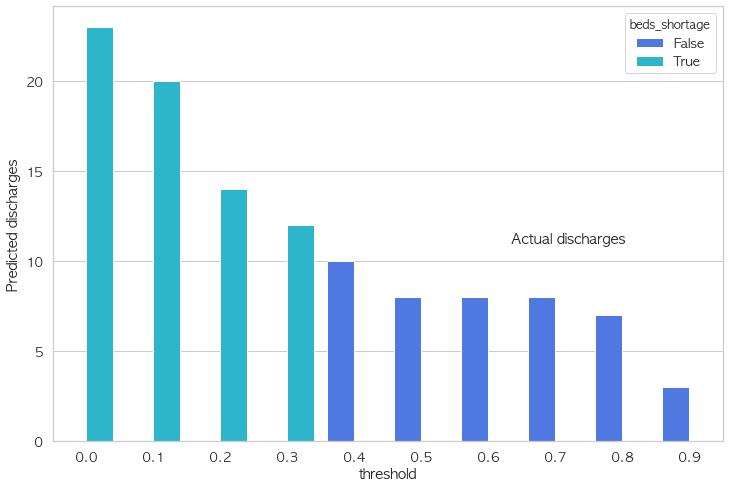

In [41]:
sns.set(style="whitegrid",font_scale=1.2,font='AppleGothic', palette="rainbow")
plt.figure(figsize=(12,8))
plt.tight_layout()
ax = sns.barplot(x='threshold',y='predicted_discharges', hue='beds_shortage',
             data= sample[sample.threshold *100 % 10 == 0]
            )
#ax.set_title('Simulation of discharges for a sample day (2019-11-9)')
ax.set(ylabel='Predicted discharges')
plt.annotate(s='Actual discharges',xy=(0.1,0.5),xytext=(0.7,0.5),xycoords='figure fraction')

plt.show()


plt.figure(figsize=(10,6))
ax = sns.lineplot(x='threshold',y='predicted_discharges', 
             data= prediction_results[(prediction_results['date'] == datetime.date(2019,3,24))],
            )
ax.set_title('')
ax.set(ylabel='')
plt.show()

In [43]:
summary = prediction_results.groupby('threshold')['predicted_discharges_happened'].mean().reset_index()

In [81]:
summary = prediction_results.groupby('threshold')[['predicted_discharges_happened','accuracy','recall','precision']].mean().reset_index()

In [82]:
summary

,threshold,predicted_discharges_happened,accuracy,recall,precision
0,0.00,0.000000,0.141895,1.000000,0.141895
1,0.01,0.000000,0.149516,1.000000,0.142974
2,0.02,0.000000,0.157197,1.000000,0.144013
3,0.03,0.000000,0.175252,0.999818,0.146390
4,0.04,0.000000,0.190123,0.997608,0.148282
5,0.05,0.000000,0.205921,0.996091,0.150265
6,0.06,0.000000,0.224056,0.994506,0.152513
7,0.07,0.000000,0.243663,0.992200,0.155120
8,0.08,0.000000,0.264248,0.987789,0.157920
9,0.09,0.000000,0.284773,0.985622,0.161073


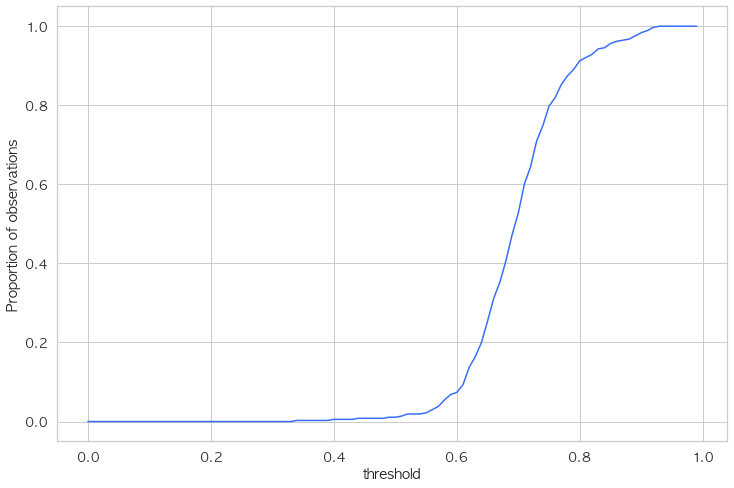

In [108]:
sns.set(style="whitegrid",font_scale=1.2,font='AppleGothic', palette="rainbow")
plt.figure(figsize=(12,8))
ax = sns.lineplot(x=summary['threshold'],y=summary['predicted_discharges_happened']
            )
#ax.set_title('Actual discharges are at least the predicted discharges?')
ax.set(ylabel='Proportion of observations')
plt.show()

In [46]:
pd.set_option('display.max_rows', None)

In [84]:
summary['confidence'] = summary['predicted_discharges_happened']

In [129]:
summary.iloc[list(range(0,100,5))]

,threshold,predicted_discharges_happened,accuracy,recall,precision,confidence
0,0.00,0.000000,0.141895,1.000000,0.141895,0.000000
5,0.05,0.000000,0.205921,0.996091,0.150265,0.000000
10,0.10,0.000000,0.305027,0.983522,0.164324,0.000000
15,0.15,0.000000,0.406358,0.960765,0.184003,0.000000
20,0.20,0.000000,0.492045,0.934592,0.206338,0.000000
25,0.25,0.000000,0.560925,0.908653,0.229690,0.000000
30,0.30,0.000000,0.617265,0.878971,0.252817,0.000000
35,0.35,0.002732,0.666192,0.845392,0.276616,0.002732
40,0.40,0.005464,0.710043,0.813060,0.303804,0.005464
45,0.45,0.008197,0.745790,0.773561,0.329206,0.008197


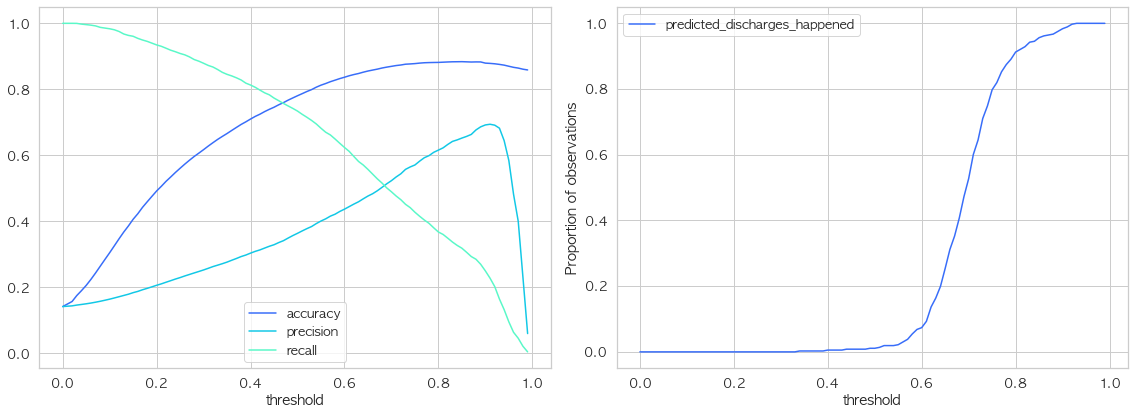

In [155]:
sns.set(style="whitegrid",font_scale=1.2,font='AppleGothic', palette="rainbow")
fig, axs = plt.subplots(1,2,figsize=(16,6), sharex=True)
summary.plot.line(x='threshold', y=['accuracy','precision','recall'],
                  ax=axs[0])
summary.plot.line(x='threshold', y=['predicted_discharges_happened'],
                 ax=axs[1])
axs[1].set_ylabel('Proportion of observations')
plt.tight_layout()

In [138]:
confidence_dict = {'95': summary[summary['confidence']> 0.95]['threshold'].min(),
                  '80': summary[summary['confidence']> 0.80]['threshold'].min(),
                  '70': summary[summary['confidence']> 0.70]['threshold'].min()}

In [139]:
summary[summary['threshold'].isin(confidence_dict.values())]

,threshold,predicted_discharges_happened,accuracy,recall,precision,confidence
73,0.73,0.710383,0.876161,0.451676,0.557565,0.710383
76,0.76,0.819672,0.879469,0.415523,0.582375,0.819672
85,0.85,0.956284,0.883845,0.318711,0.652348,0.956284


In [140]:
summary[summary['threshold'].isin(confidence_dict.values())].to_csv('thresholds_summary.csv')

In [141]:
summary[summary['confidence'].isin([0.95,0.8,0.7])]

,threshold,predicted_discharges_happened,accuracy,recall,precision,confidence


In [142]:
confidence_dict.values()

dict_values([0.85, 0.76, 0.73])

In [143]:
import json

In [144]:
with open('confidence_dict.json', 'w') as json_file:
    json.dump(confidence_dict, json_file)

In [145]:
with open('confidence_dict.json', 'r') as json_file:
    confidence_dict = json.load(json_file)

In [146]:
confidence_dict

{'95': 0.85, '80': 0.76, '70': 0.73}

In [147]:
def forecast_discharges(date, confidence_thresholds=confidence_dict):
    
    data = Data().load('data/hospital_dataset')
    date_data = data.test.X[data.test.X['date']== date ]
    
    output = {'confidence %': [],
             'lower bound forecast': []}  
    
    with open(r"experiments/optimized_gdbt_model.pkl", "rb") as input_file:
        lgbm_model = pkl.load(input_file)
        
    transformed_data = lgbm_model.pipeline.transform(date_data)
    predictions = lgbm_model.predict(transformed_data)
    
    
    for confidence_level in confidence_thresholds:
        threshold = confidence_thresholds[confidence_level]
        forecast = sum([1 for prob in predictions if prob > threshold])
        
        print(('With {p} % of confidence, number of discharges will be at least {N}'
                .format(p=confidence_level,N=forecast)))
        
        output['confidence %'].append(confidence_level)
        output['lower bound forecast'].append(forecast)
    
    
    return pd.DataFrame(output) 

In [148]:
date_df = data.test.X[data.test.X['date']== unique_dates[20]]

In [149]:
unique_dates[20]

datetime.date(2019, 10, 22)

In [150]:
import warnings
warnings.filterwarnings('ignore')

In [151]:
date = datetime.date(2019,10,22)
forecast_discharges(date)

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet
Loading dataset:  hospital_test_data.parquet
With 95 % of confidence, number of discharges will be at least 6
With 80 % of confidence, number of discharges will be at least 9
With 70 % of confidence, number of discharges will be at least 10


,confidence %,lower bound forecast
0,95,6
1,80,9
2,70,10
